# Imports and Utility functions

In [1]:
from __future__ import print_function
import torch
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## NMS function

In [2]:
def nms_pytorch(P : torch.tensor ,thresh_iou : float):
    """Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """

    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    # we extract the confidence scores as well
    scores = P[:, 4]

    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
    
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()

    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
    

    while len(order) > 0:
        
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]

        # push S in filtered predictions list
        keep.append(P[idx])

        # remove S from P
        order = order[:-1]

        # sanity check
        if len(order) == 0:
            break
        
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
        
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        # find the intersection area
        inter = w*h

        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
        
        # find the IoU of every prediction in P with S
        IoU = inter / union

        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
    
    return keep

In [3]:
# !wget https://learnopencv.com/wp-content/uploads/2021/06/data.zip
# !unzip data.zip

In [4]:
def _save_image(img_name,raw_img,boxes):
    """Utility function to save an image with
       prediction boxes
    """
    
    # iterate over every BBox
    for b in boxes:
        text = "{:.4f}".format(b[4])
        b = list(map(int, b))
        cv2.rectangle(raw_img, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
    
    cv2.imwrite(img_name, raw_img)
    return(cv2.cvtColor(raw_img,cv2.COLOR_BGR2RGB))

In [5]:
def _read_file(file_name = 'labels.txt'):
    """Utility function to read the file
       containing prediction boxes and return
       a tensor
    """
    # read the labels file
    file = open('labels.txt','r')
    boxes = []
    for line in file:
        # remove new line char
        line = line[:-2]
        line = line.split(' ')
        box = [float(num) for num in line]
        boxes.append(box)
    
    file.close()
    boxes = torch.tensor(boxes) 
    return boxes

In [6]:
def _load_image(image_path = 'sample.jpg'):
    """Utility function to read an image and return
       in raw form.
    """
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_raw=cv2.resize(img_raw,(633,633))
    return img_raw

Read the `labels.txt` file

In [7]:
boxes = _read_file()

Print the `boxes.shape`. We see there are total of 309 predictions.

In [8]:
boxes.shape

torch.Size([309, 5])

If we look at any random prediction BBox, we see that it is of the form `(x1,y1,x2,y2,c)` where `(x1,y1)` is the bottom left corner of the BBox and `(x2,y2)` is the upper right corner of the BBox and `c` is the class prediction score

In [9]:
boxes[10]

tensor([335.0970,  71.8290, 393.5530, 196.8940,   0.7440])

Apply NMS over the prediction BBoxes

In [10]:
filtered_boxes = nms_pytorch(boxes,thresh_iou=0.5)

If we look at `filtered_boxes`, we see that out of `309` predictions only `9` remained after applying NMS.

In [11]:
filtered_boxes

[tensor([321.0950, 325.1020, 393.6710, 455.9300,   0.9940]),
 tensor([ 75.7170, 155.0710, 143.9270, 274.0190,   0.9930]),
 tensor([ 60.7890, 357.5100, 130.7250, 484.8780,   0.9880]),
 tensor([493.2310, 338.0570, 561.1060, 474.9590,   0.9810]),
 tensor([405.5730,  97.7150, 471.9640, 229.7850,   0.9800]),
 tensor([199.3570, 347.2870, 263.9680, 480.0680,   0.9760]),
 tensor([333.1320,  70.1250, 391.6350, 196.2080,   0.9680]),
 tensor([262.9670, 167.8600, 321.5730, 280.3220,   0.9670]),
 tensor([170.7110, 104.0130, 232.0630, 230.4070,   0.9600])]

Now we load the corresponding image and plot the prediction boxes before and after we applied NMS to compare.

In [12]:
img = _load_image()

In [13]:
img_before_nms = _save_image('before_nms.jpg',img.copy(),boxes)

In [14]:
img_after_nms = _save_image('after_nms.jpg',img.copy(), filtered_boxes)

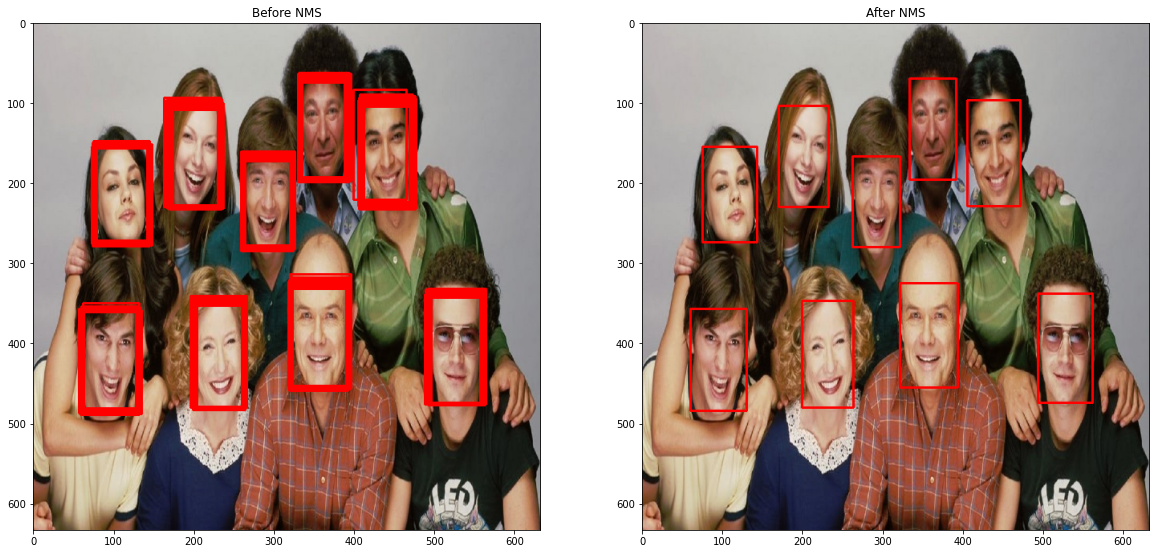

In [15]:
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title("Before NMS")
plt.imshow(img_before_nms)
plt.subplot(122)
plt.title("After NMS")
plt.imshow(img_after_nms)
